# **Algorithmic Methods of Data Mining - Fall 2022**

## **Homework 4: Getting to know your customers**

**Packages that are used troughout the notebook:**

In [3]:
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import numpy as np
import datasets

# For progress_apply
tqdm.pandas()

datas = datasets.Datasets()

## 1. Finding Similar Costumers

### 1.1 Set up the data

In [4]:
transactions = datas.getTransactions().copy()
transactions.head()

,tid,cid,cdob,cgender,clocation,cbalance,tdate,tamount
0,T1,0,1994-01-10,F,JAMSHEDPUR,17819.05,2016-08-02 14:32:07,25.0
1,T2,1,2057-04-04,M,JHAJJAR,2270.69,2016-08-02 14:18:58,27999.0
2,T3,2,1996-11-26,F,MUMBAI,17874.44,2016-08-02 14:27:12,459.0
3,T4,3,1973-09-14,F,MUMBAI,866503.21,2016-08-02 14:27:14,2060.0
4,T5,4,1988-03-24,F,NAVI MUMBAI,6714.43,2016-08-02 18:11:56,1762.5


In [5]:
customers = datas.getCustomers().copy()
customers.head()

,dob,gender,location,balance
cid,,,,
0,1994-01-10,F,JAMSHEDPUR,17819.05
1,1957-04-04,M,JHAJJAR,2270.69
2,1996-11-26,F,MUMBAI,17874.44
3,1973-09-14,F,MUMBAI,866503.21
4,1988-03-24,F,NAVI MUMBAI,6714.43


We will create shingles for each customer by using their age, average transaction amount, and balance. To do this, we are going to divide these variables into 10 quantiles, and assign a quantile to each customer. For example, if a customer is in the 1st quantile for age, and in the 3rd quantile for average transaction amount, and in the 5th quantile for balance, then the shingle for that customer will be [age_1, avg_tamount_3, balance_5].

In [6]:
customers['age'] = ((transactions['tdate'].max() - customers['dob']).dt.days // 365).astype(int)
customers['ave_tamount'] = transactions.groupby('cid')['tamount'].mean()

In [7]:
quantiles = 10
customers['age_group'] = pd.qcut(customers['age'], quantiles, labels=False)
customers['balance_group'] = pd.qcut(customers['balance'], quantiles, labels=False)
customers['tamount_group'] = pd.qcut(customers['ave_tamount'], quantiles, labels=False)

We will also store these quantiles in a dictionary, so that we can easily find the quantile of a variable for a given customer.

In [8]:
age_groups = pd.qcut(customers['age'], quantiles).unique().sort_values()
balance_groups = pd.qcut(customers['balance'], quantiles).unique().sort_values()
tamount_groups = pd.qcut(customers['ave_tamount'], quantiles).unique().sort_values()

In [9]:
def getGroup(group, value):
    return np.where([value in g for g in group])[0][0] if len(np.where([value in g for g in group])[0]) > 0 else None

getGroup(age_groups, 29)

4

Now we are going to create our shingle matrix.

In [10]:
# make dummy variables for categorical variables
shingles = pd.DataFrame(index=customers.index)
shingles = pd.concat([shingles, pd.get_dummies(customers['age_group'], prefix='age')], axis=1)
shingles = pd.concat([shingles, pd.get_dummies(customers['balance_group'], prefix='balance')], axis=1)
shingles = pd.concat([shingles, pd.get_dummies(customers['tamount_group'], prefix='tamount')], axis=1)
# transpose to get the shingles
shingles = shingles.T
shingles.head()

cid,0,1,2,3,4,5,6,7,8,9,...,162301,162302,162303,162304,162305,162306,162307,162308,162309,162310
age_0,1,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
age_1,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
age_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
age_3,0,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
age_4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 1.2 Fingerprint hashing

In [11]:
# import sparse matrix for shingles
from scipy import sparse

def get_signatures(shingles, signature_length: int) -> np.ndarray:
    # set seed for reproducibility
    np.random.seed(123)
    signatures = np.full((signature_length, shingles.shape[1]), np.nan, dtype=np.int32)
    for i in range(signature_length):

        idx = np.random.choice(shingles.index, shingles.shape[0], replace=False)
        sparse_shingles = sparse.csc_matrix(shingles.loc[idx].values)
        rowidx = sparse_shingles.nonzero()[0]
        colidx = sparse_shingles.nonzero()[1]
        signatures[i,:] = rowidx[np.unique(colidx, return_index=True)[1]]
    return signatures

In [12]:
signatures = get_signatures(shingles, signature_length=20)
signatures.shape

(20, 162311)

In [13]:
def create_buckets(signatures, band_size):
    buckets = {}
    rows = signatures.shape[0] // band_size
    for i in range(rows):
        for j in range(signatures.shape[1]):
            bucket = (i, *signatures[i*band_size:(i+1)*band_size, j])
            if bucket not in buckets:
                buckets[bucket] = []
            buckets[bucket].append(j)
    return buckets

In [14]:
# check if equal
band_size = 2
buckets = create_buckets(signatures, band_size=2)

#### 1.3 Locality Sensitive Hashing

Now, we first parse query so that it is in the same format as the shingles.

In [15]:
query_users = datas.getQueryUsers()
query_users['age_group'] = query_users['age'].apply(lambda x: getGroup(age_groups, x))
query_users['balance_group'] = query_users['balance'].apply(lambda x: getGroup(balance_groups, x))
query_users['tamount_group'] = query_users['tamount'].apply(lambda x: getGroup(tamount_groups, x))
query_users.index = range(len(query_users))

query_shingles = pd.DataFrame(index=query_users.index)
query_shingles = pd.concat([query_shingles, pd.get_dummies(query_users['age_group'], prefix='age')], axis=1)
query_shingles = pd.concat([query_shingles, pd.get_dummies(query_users['balance_group'], prefix='balance')], axis=1)
query_shingles = pd.concat([query_shingles, pd.get_dummies(query_users['tamount_group'], prefix='tamount')], axis=1)
query_shingles = query_shingles.T

query_signatures = get_signatures(query_shingles, signature_length=20)

query_shingles.head()

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
age_0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
age_1,0,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
age_2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
age_3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
age_4,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


We have implemented 2 functions to query users. The first takes intersection of all the matching buckets, and the second takes union of all the matching buckets.

In [16]:
def get_intersection(buckets, query_signatures, band_size):

    intersection = {j: set() for j in range(query_signatures.shape[1])}
    num_bucket_matches = {j: 0 for j in range(query_signatures.shape[1])}

    rows = query_signatures.shape[0] // band_size

    for i in range(rows):
        for j in range(query_signatures.shape[1]):
            bucket = (i, *query_signatures[i*band_size:(i+1)*band_size, j])
            if bucket in buckets.keys():
                intersection[j] = intersection[j] & set(buckets[bucket]) if len(intersection[j]) > 0 else set(buckets[bucket])
                num_bucket_matches[j] += 1

    return intersection, num_bucket_matches

def get_unions(buckets, query_signatures, band_size):

    unions = {j: set() for j in range(query_signatures.shape[1])}
    num_bucket_matches = {j: 0 for j in range(query_signatures.shape[1])}

    rows = query_signatures.shape[0] // band_size

    for i in range(rows):
        for j in range(query_signatures.shape[1]):
            bucket = (i, *query_signatures[i*band_size:(i+1)*band_size, j])
            if bucket in buckets.keys():
                unions[j] = unions[j].union(buckets[bucket])
                num_bucket_matches[j] += 1

    return unions, num_bucket_matches

In [17]:
band_size = 2

buckets = create_buckets(signatures, band_size=band_size)

intersections, _ = get_intersection(buckets, query_signatures, band_size=band_size)
print('Number of matching customers by intersection for the first 10 queries:')
for i in range(10):
    print(len(intersections[i]), end='\t')


print('\nNumber of matching customers by union for the first 10 queries:')
unions, _ = get_unions(buckets, query_signatures, band_size=band_size)
for i in range(10):
    print(len(unions[i]), end='\t')


Number of matching customers by intersection for the first 10 queries:
602	0	0	0	849	289	1506	0	6188	13218	
Number of matching customers by union for the first 10 queries:
14142	16841	17378	19515	5050	1343	3395	3816	17167	17797	

As you can see above, sometimes the intersection of the buckets is empty. In order to consistently rely on this method we must tune the number shingles and bands to make sure that the intersection is not empty. Let's inspect an example where we get a non-empty intersection.

In [18]:
# get last query user
query_users.iloc[-1]

dob              1987-01-05 00:00:00
balance                     10989.03
tamount                        240.0
age                               29
age_group                          4
balance_group                      4
tamount_group                      1
Name: 45, dtype: object

In [19]:
customers.iloc[list(intersections[45])].head()

,dob,gender,location,balance,age,ave_tamount,age_group,balance_group,tamount_group
cid,,,,,,,,,
42369,1987-08-23,F,ZIRAKPUR,11676.35,29,104.80000,4,4,0
143874,1987-06-22,F,MORADABAD,10718.28,29,51.00000,4,4,0
73089,1987-05-30,M,AURANGABAD,8694.41,29,30.00000,4,4,0
45444,1987-05-19,M,CHIREMIRI,11239.49,29,102.83871,4,4,0
99076,1987-05-17,M,NARSANDA,10102.55,29,125.00000,4,4,0


The customers above are pretty similar in their balance, transaction amount, and age. So we can say that our algorithm is working for some cases.

## 2. Grouping customers together!

### 2.1 Set up the data

#### 2.1.1 Cleaning transactions data

#### 2.1.2 Customer data

In [20]:
customersX = datas.getCustomersX().copy()
customersX[customersX.columns[:9]].head()

,dob,age,gender,location,balance,num_t,num_t_g100,avg_tamount,utilisation
cid,,,,,,,,,
0,1994-01-10,22,F,JAMSHEDPUR,17819.05,27,9,80.111111,17738.938889
1,1957-04-04,59,M,JHAJJAR,2270.69,12,11,9503.445000,-7232.755000
2,1996-11-26,19,F,MUMBAI,17874.44,11,10,940.348182,16934.091818
3,1973-09-14,43,F,MUMBAI,866503.21,13,13,2537.346923,863965.863077
5,1972-10-08,44,F,ITANAGAR,53609.20,11,11,1418.909091,52190.290909


So we are sparing you to look at all the data cleaning and preprocessing we did, at least in this notebook. You may find the code in datasets.py file. Rather we are going to go over the variables we created and how we created them. So as we have explaiend before we have created new customer IDs. And the data we have for these customers have unique gender, location, balance; thus the 3 of the 7 variables that you asked for is automatically implemented. We have calculated the other 4 variables which were required.

In [21]:
customersX[customersX.columns[9:]].head()

,tamount_balance_ratio,log_balance,log_tamount,balance_age_ratio,balance_leq_avg_salary,top_30_loc,transaction_freq_std,t_max,t_min,t_std,t_skew,t_kurt,transaction_freq,vol_weighted_transaction_freq,tamount_age_ratio,boomer,zoomer,days_till_bd,zodiac
cid,,,,,,,,,,,,,,,,,,,
0,0.004496,9.788080,4.395820,809.956818,True,False,30153.912763,270.0,4.00,88.562596,1.241343,0.196795,41.361702,3313.531915,3.641414,False,False,285,Capricorn
1,4.185267,7.728279,9.159515,38.486271,True,False,34481.324726,27999.0,75.05,12228.759447,0.883882,-1.225921,1.558020,14806.557533,161.075339,False,False,200,Aries
2,0.052609,9.791183,6.847313,940.760000,True,True,24111.348841,7196.0,45.00,2085.637967,3.254038,10.695982,5.469613,5143.340884,49.492010,False,True,36,Sagittarius
3,0.002928,13.672222,7.839268,20151.237442,False,True,32051.120040,6924.0,450.00,1636.970616,1.848912,4.021366,0.262788,666.785535,59.008068,False,False,37,Virgo
5,0.026468,10.889495,7.258348,1218.390909,False,False,40957.262504,2620.0,499.00,665.213117,0.354168,-0.402150,5.111326,7252.507260,32.247934,False,False,13,Libra


Moving on, you can see the variables we have added to the data. We have added the following variables:
1. **age**: The age of the customer
2. **tamount_balance_ratio**: The ratio of the average transaction amount to the balance of the customer
3. **log_balance**: The log of the balance of the customer
4. **log_tamount**: The log of the average transaction amount of the customer
5. **balance_age_ratio**: The ratio of the balance to the age of the customer
6. **balance_leq_avg_salary**: Whether the balance of the customer is less than or equal to the average salary in India, that is 3200 INR.
7. **top_30_loc**: Whether the customer is from one of the top 30 most frequent locations in the dataset.
8. **tranaction_freq**: The frequency of the transactions of the customer.
9. **transaction_freq_std**: The standard deviation of the transaction frequency of the customer. This is to indicate how consistent the customer is in terms of transaction frequency.
10. **vol_weighted_transaction_freq**: The volume weighted transaction frequency of the customer. This is to indicate how much the customer spends in terms of transaction frequency.
11. **t_max**: The maximum transaction amount of the customer.
12. **t_min**: The minimum transaction amount of the customer.
13. **t_std**: The standard deviation of the transaction amount of the customer.
14. **t_skew**: The skewness of the transaction amount of the customer.
15. **t_kurt**: The kurtosis of the transaction amount of the customer.
16. **tamount_age_ratio**: The ratio of the average transaction amount to the age of the customer.
17. **boomer**: Whether the customer is a boomer or not, that is, above 60 years of age.
18. **zoomer**: Whether the customer is a zoomer or not, that is, below 20 years of age.
19. **days_till_bd**: The number of days till the customer's birthday. This can eliminate extra spending due to customer's birthday.
20. **zodiac**: The zodiac sign of the customer.

#### 2.2 Choose your features (variables)!

We will standardize our data before clustering because we want to give **equal importance** to all the variables. We will drop the location, zodiac variables because we believe it will cause overfitting. We will also convert columns with boolean values to 0 and 1.

In [22]:
X = customersX.copy()
X.drop(['dob', 'location', 'zodiac'], axis=1, inplace=True)
X.loc[:, X.dtypes == 'bool'] = X.loc[:, X.dtypes == 'bool'].astype('int')
X['gender'] = X['gender'].apply(lambda x: 1 if x == 'M' else 0)
print('The number of non-numeric features is: ', sum([x not in ['int64', 'float64'] for x in X.dtypes]))

The number of non-numeric features is:  0


In [23]:
X = (X - X.mean()) / X.std()
print('The number of cols with absolute mean larger than 0.001 is: ', sum(abs(X.mean()) > 0.001))
print('The number of cols with absolute std larger than 1.0001 or smaller than 0.9999 is: ', sum(abs(X.std() - 1) > 0.001) + sum(X.std() < 0.9999))

The number of cols with absolute mean larger than 0.001 is:  0
The number of cols with absolute std larger than 1.0001 or smaller than 0.9999 is:  0


The number of PCA components that explain 70% of the variance is:  9


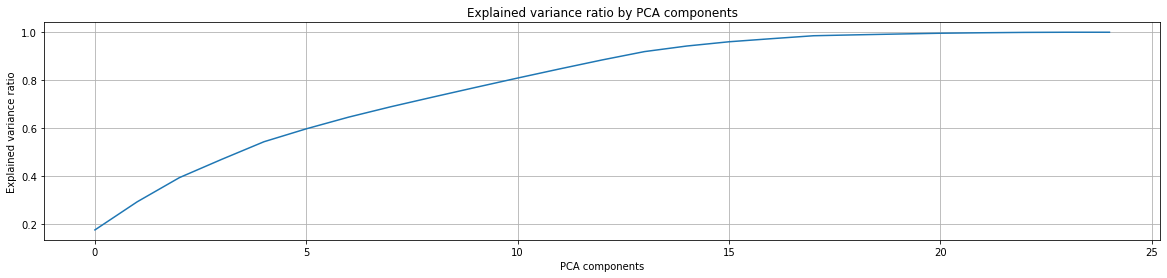

In [24]:
# import pca
from sklearn.decomposition import PCA
pca = PCA().fit(X)
# Plot the explained variance
pd.Series(np.cumsum(pca.explained_variance_ratio_)).plot(
    title='Explained variance ratio by PCA components',
    figsize=(20, 4),
    grid=True,
    xlabel='PCA components',
    ylabel='Explained variance ratio'
)

print('The number of PCA components that explain 70% of the variance is: ', np.where(np.cumsum(pca.explained_variance_ratio_) > 0.70)[0][0] + 1)

In [25]:
pca = PCA(n_components=9).fit(X)
XPC = pca.transform(X)

#### 2.3 Clustering!

In [26]:
from pyspark import SparkContext

def assign_cluster(row, centroids):
    cluster = np.argmin(np.sum((centroids - row) ** 2, axis=1))
    return (cluster, (1, row))


def update_centroids(x, y):
    # Returns the sum of number of observations and the sum of the rows
    return (x[0] + y[0], x[1] + y[1])

def kmeans(X, k, max_iter=10):
    sc = SparkContext.getOrCreate()
    rdd = sc.parallelize(X)

    centroids = X[np.random.choice(X.shape[0], k, replace=False), :]

    for j in (pbar:= tqdm(range(max_iter), desc='KMeans iterations')):
        mapResults = rdd.map(lambda x: assign_cluster(x, centroids)).reduceByKey(update_centroids).collect()
        centroids = np.array([mapResults[i][1][1] / mapResults[i][1][0] for i in range(k)])

        
        clusters = [row[0] for row in rdd.map(lambda x: assign_cluster(x, centroids)).collect()]
        sse = np.sum((np.dot(pd.get_dummies(clusters).values, centroids) - X) ** 2)
        pbar.set_description(f'KMeans iterations {j + 1}/{max_iter} (SSE: {sse:.2f})')


    return clusters, centroids

In [27]:
clusters, centroids = kmeans(XPC, 5, 20)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/02 12:37:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


KMeans iterations 20/20 (SSE: 384488.82): 100%|██████████| 20/20 [00:45<00:00,  2.29s/it]


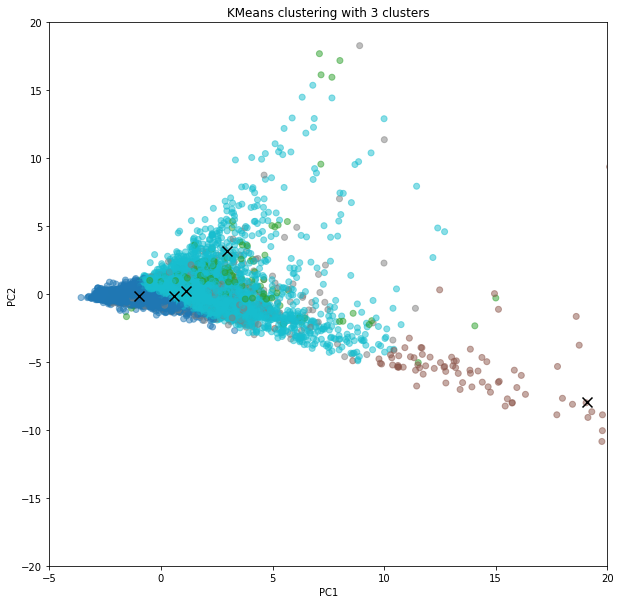

In [28]:
import matplotlib.pyplot as plt
# Plot according to the first two principal components
plt.figure(figsize=(10, 10))
plt.scatter(XPC[:, 0], XPC[:, 1], c=clusters, cmap='tab10', alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, c='k')
plt.title('KMeans clustering with 3 clusters')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.xlim(-5,20); plt.ylim(-20,20)
plt.show()

#### 2.4 Analysing your results!

### Bonus

### Command Line Question

In [29]:
%%bash

echo '1-The location that has the maximum number of purchases been made:'

awk -F, '{print($5)}' data/bank_transactions.csv | sort | uniq -c | sort -nr | head -1

echo '2-The most spending purchases are: '

awk -F, '{$4+=$9}END{ if(list["F"] > list["M"]){ print("F");} else{ print("M");}}' data/bank_transactions.csv

echo '3-The customer with the highest average transaction amount: '

awk -F, '{c[$2]++;list[$2]+=$9}END{for (i in list) print(list[i]/c[i],i)}' data/bank_transactions.csv | sort -nr | head -1

1-The location that has the maximum number of purchases been made:
103595 MUMBAI
2-The most spending purchases are: 
M
3-The customer with the highest average transaction amount: 
991132 C4141768


### Algorithmic Question

In [30]:
# N, M, G = list(map(int, input().split()))
# arriving = list(map(int, input().split()))


N, M, G = 4, 5, 1
arriving = [1, 1, 3, 3, 3]

N, M, G = 2, 5, 1
arriving = [1, 2, 1]


print(f'N = {N}, M = {M}, G = {G}')
print(f'arriving = {arriving}')

enough = True

intersections = {}

for student in arriving:
    if student not in intersections.keys():
        intersections[student] = set()
        intersections[student].add(student)
    else:
        for gate in intersections.keys():
            intersections[gate].add(student)

for gate in intersections.keys():
    if len(intersections[gate]) > G:
        enough = False

if enough:
    print('YES')
else:
    print('NO')

N = 2, M = 5, G = 1
arriving = [1, 2, 1]
NO
